In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime
import keras
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
gpu = physical_devices[0]
gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

# Preprocessing

In [3]:
# functions get_MACD, get_RSI, get_closed_dates, get_PRICE are extracted from:
# https://www.kaggle.com/code/korfanakis/stock-technical-indicators-for-tesla-macd-rsi

In [4]:
def get_MACD(df, column='Adj Close'):
    """Return a new DataFrame with the MACD and related information (signal line and histogram)."""
    df['EMA-12'] = df[column].ewm(span=12, adjust=False).mean()
    df['EMA-26'] = df[column].ewm(span=26, adjust=False).mean()

    # MACD Indicator = 12-Period EMA − 26-Period EMA.
    df['MACD'] = df['EMA-12'] - df['EMA-26']

    # Signal line = 9-day EMA of the MACD line.
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Histogram = MACD - Indicator.
    df['Histogram'] = df['MACD'] - df['Signal']

    return df

In [5]:
def get_RSI(df, column='Adj Close', time_window=14):
    """Return the RSI indicator for the specified time window."""
    diff = df[column].diff(1)

    # This preservers dimensions off diff values.
    up_chg = 0 * diff
    down_chg = 0 * diff

    # Up change is equal to the positive difference, otherwise equal to zero.
    up_chg[diff > 0] = diff[diff > 0]

    # Down change is equal to negative deifference, otherwise equal to zero.
    down_chg[diff < 0] = diff[diff < 0]

    # We set com = time_window-1 so we get decay alpha=1/time_window.
    up_chg_avg = up_chg.ewm(com=time_window - 1,
                            min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1,
                                min_periods=time_window).mean()

    RS = abs(up_chg_avg / down_chg_avg)
    df['RSI'] = 100 - 100 / (1 + RS)

    return df

In [6]:
def get_closed_dates(df):
    """Return a list containing all dates on which the stock market was closed."""
    # Create a dataframe that contains all dates from the start until today.
    timeline = pd.date_range(start=df['Date'].iloc[0], end=df['Date'].iloc[-1])

    # Create a list of the dates existing in the dataframe.
    df_dates = [day.strftime('%Y-%m-%d') for day in pd.to_datetime(df['Date'])]

    # Finally, determine which dates from the 'timeline' do not exist in our dataframe.
    closed_dates = [
        day for day in timeline.strftime('%Y-%m-%d').tolist()
        if not day in df_dates
    ]

    return closed_dates


In [7]:
def get_price(ticker, start_date, end_date):
    """Return a DataFrame with price information (open, high, low, close, adjusted close, and volume) for the ticker between the specified dates."""
    df = yf.download(ticker, start_date, end_date, progress=False)
    df.reset_index(inplace=True)

    return df

In [8]:
ticker = 'TSLA'
no_years = 10

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() -
              datetime.timedelta(days=no_years * 365)).strftime('%Y-%m-%d')

print('Ticker: {}'.format(ticker))
print('Start Date: ', start_date)
print('  End Date: ', end_date)

df = get_price(ticker, start_date, end_date)
df = get_MACD(df)
get_RSI(df).describe()

Ticker: TSLA
Start Date:  2014-09-08
  End Date:  2024-09-05


,Date,Open,High,Low,Close,Adj Close,Volume,EMA-12,EMA-26,MACD,Signal,Histogram,RSI
count,2515,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2501.000000
mean,2019-09-04 11:27:04.652087552,106.379632,108.714915,103.894488,106.354047,106.354047,1.123110e+08,105.929450,105.384319,0.545131,0.547668,-0.002536,52.085676
min,2014-09-08 00:00:00,9.488000,10.331333,9.403333,9.578000,9.578000,1.062000e+07,10.878716,11.822299,-25.271333,-22.213158,-7.678481,16.564126
25%,2017-03-07 12:00:00,16.689000,16.933332,16.464000,16.701334,16.701334,6.666645e+07,16.663529,16.490918,-0.532583,-0.461035,-0.215203,43.024371
50%,2019-09-05 00:00:00,23.615999,23.966000,23.304667,23.620667,23.620667,9.290520e+07,23.335478,23.061841,0.063147,0.074032,0.015980,50.940943
75%,2022-03-03 12:00:00,209.881668,215.591667,205.285004,209.769997,209.769997,1.301730e+08,212.711392,213.925944,1.457582,1.409626,0.260768,60.994536
max,2024-09-04 00:00:00,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08,371.838585,357.497094,38.067930,31.285426,10.296174,94.197983
std,NaN,109.350774,111.788733,106.686956,109.259430,109.259430,7.418752e+07,108.750959,108.138873,6.645333,6.227359,2.073377,13.533491


Text(0.5, 1.0, 'TSLA Stock')

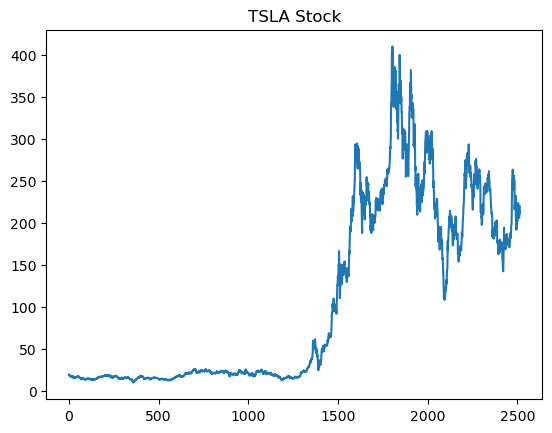

In [9]:
plt.plot(np.arange(2515), df["Close"])
plt.title("TSLA Stock")

In [10]:
no_years = 10
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() -
              datetime.timedelta(days=no_years * 365)).strftime('%Y-%m-%d')

companies_name = 'TSLA NVDA GOOGL META'

companies = yf.Tickers(companies_name)
all_prices = [get_price(ticker, start_date, end_date)[["Open", "High", "Low", "Close", "Adj Close"]] for ticker in companies_name.split()]
all_prices = pd.concat(all_prices)

all_macd =  [get_MACD(get_price(ticker, start_date, end_date))["MACD"] for ticker in companies_name.split()]
all_macd = pd.concat(all_macd)

all_rsi =  [get_RSI(get_price(ticker, start_date, end_date))["RSI"] for ticker in companies_name.split()]
all_rsi = pd.concat(all_rsi)

In [11]:
all_data = pd.concat([all_prices, all_macd, all_rsi], axis=1)
all_data.fillna(0, inplace=True)

In [12]:
all_data.describe()

,Open,High,Low,Close,Adj Close,MACD,RSI
count,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000
mean,101.697909,103.231384,100.156855,101.730423,101.606564,0.614503,53.885173
std,105.001674,106.641620,103.348411,105.014440,104.899786,4.527881,13.107459
min,0.423250,0.432500,0.419250,0.419750,0.401343,-28.986746,0.000000
25%,17.055500,17.430168,16.799250,17.125000,17.105331,-0.279625,45.171804
50%,60.257000,60.768000,59.889000,60.361000,60.291803,0.160015,54.134202
75%,163.909996,166.172497,161.242504,163.755005,163.578461,1.362436,63.008967
max,542.349976,544.229980,528.590027,539.909973,539.909973,38.067930,94.197983


In [13]:
all_data[["Open", "High", "Low", "Close", "Adj Close", "MACD", "RSI"]]

,Open,High,Low,Close,Adj Close,MACD,RSI
0,18.507999,18.992001,18.501333,18.807333,18.807333,0.000000,0.000000
1,18.865999,19.032667,18.466667,18.565332,18.565332,-0.019305,0.000000
2,18.633333,18.760668,18.243999,18.740000,18.740000,-0.020276,0.000000
3,18.697332,18.986000,18.575333,18.687332,18.687332,-0.025008,0.000000
4,18.700001,18.826000,18.466667,18.613333,18.613333,-0.034333,0.000000
...,...,...,...,...,...,...,...
2510,517.669983,521.090027,512.450012,516.780029,516.780029,8.305984,52.438418
2511,519.049988,527.200012,515.679993,518.219971,518.219971,7.466930,53.164949
2512,521.349976,523.539978,515.200012,521.309998,521.309998,6.970956,54.761945
2513,519.640015,525.489990,508.619995,511.760010,511.760010,5.741109,49.180450


In [14]:
close = all_data["Close"].values.reshape(-1, 1)
macd = all_data["MACD"].values.reshape(-1, 1)
rsi = all_data["RSI"].values.reshape(-1, 1)
target = all_data["Close"].shift(-1).values.reshape(-1, 1)

In [30]:
scaler_close = StandardScaler()
scaler_macd = StandardScaler()
scaler_rsi = StandardScaler()
scaler_target = StandardScaler()

close_scaled = scaler_close.fit_transform(close)
macd_scaled = scaler_macd.fit_transform(macd)
rsi_scaled = scaler_rsi.fit_transform(rsi)
target_scaled = scaler_target.fit_transform(target)

In [31]:
target.shape

(10060, 1)

In [32]:
sequence_length = 50

X = []
y = []
for i in range(len(all_data) - sequence_length):
    X.append(np.column_stack((rsi[i:i+sequence_length], macd[i:i+sequence_length])))
    y.append(close[i + sequence_length])
X, y = np.array(X), np.array(y)

In [33]:
X.shape, y.shape

((10010, 50, 2), (10010, 1))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, y_train.shape

((7507, 50, 2), (7507, 1))

In [35]:
y_train[0]

array([-0.4522167])

# Model

In [36]:
batch_size = 32

In [75]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 50)            10600     
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_18 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [76]:
model.compile(
    loss='mse',
    metrics=['mae'],
    optimizer='rmsprop'
)

In [77]:
mean = X_train.mean(axis=0)
X_train -= mean

std = X_train.std(axis=0)
X_train /= std

X_train -= mean
X_test /= std

In [78]:
print(np.isnan(X_train).any(), np.isinf(X_train).any())
print(np.isnan(y_train).any(), np.isinf(y_train).any())


False False
False False


In [79]:
# K folds
k = 4
num_val_samples = len(X_train) // k
num_epochs = 200
all_mae_history = []

for i in range(k):
    print("processing fold #", i)
    val_data = X_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([X_train[:i * num_val_samples], X_train[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i+1) * num_val_samples:]], axis=0)

    history = model.fit(
    partial_train_data,
    partial_train_targets,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_data, val_targets)
    )

    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)



processing fold # 0
Epoch 1/200
176/176 [==============================] - 7s 22ms/step - loss: 1.4301 - mae: 0.7647 - val_loss: 1.0389 - val_mae: 0.8148
Epoch 2/200
176/176 [==============================] - 3s 19ms/step - loss: 0.8114 - mae: 0.6583 - val_loss: 0.8410 - val_mae: 0.6943
Epoch 3/200
176/176 [==============================] - 3s 20ms/step - loss: 0.6806 - mae: 0.5992 - val_loss: 0.5228 - val_mae: 0.5144
Epoch 4/200
176/176 [==============================] - 3s 20ms/step - loss: 0.5122 - mae: 0.4978 - val_loss: 0.4124 - val_mae: 0.4349
Epoch 5/200
176/176 [==============================] - 3s 20ms/step - loss: 0.4137 - mae: 0.4336 - val_loss: 0.3396 - val_mae: 0.3551
Epoch 6/200
176/176 [==============================] - 3s 20ms/step - loss: 0.3523 - mae: 0.3858 - val_loss: 0.3851 - val_mae: 0.4154
Epoch 7/200
176/176 [==============================] - 3s 20ms/step - loss: 0.3197 - mae: 0.3656 - val_loss: 0.3225 - val_mae: 0.3620
Epoch 8/200
176/176 [=====================

In [84]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

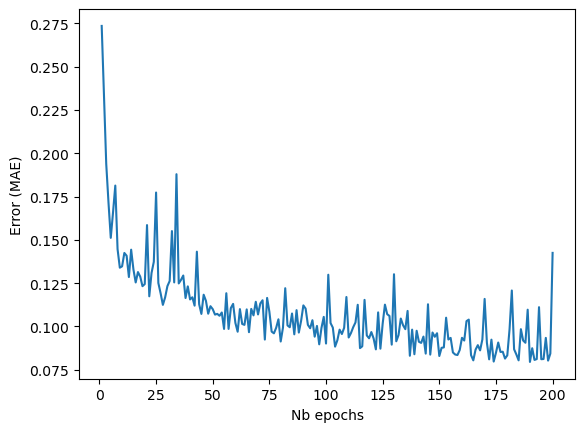

In [85]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Nb epochs')
plt.ylabel('Error (MAE)')
plt.show()

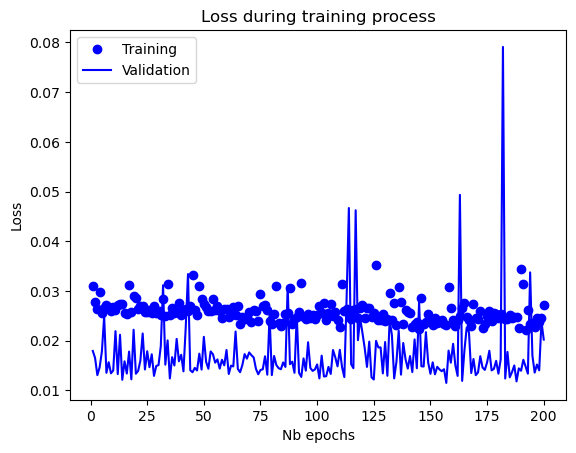

In [86]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 201)

plt.plot(epochs, loss_values, 'bo', label="Training")
plt.plot(epochs, val_loss_values, 'b', label="Validation")

plt.title("Loss during training process")
plt.xlabel("Nb epochs")
plt.ylabel("Loss")
plt.legend()

In [83]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(20))
model.add(Dense(1))
model.summary()

model.compile(
    loss='mse',
    metrics=['mae'],
    optimizer='rmsprop'
)

model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=16,
    verbose=0
)

test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 50, 20)            1840      
                                                                 
 lstm_20 (LSTM)              (None, 20)                3280      
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,141
Trainable params: 5,141
Non-trainable params: 0
_________________________________________________________________
79/79 [==============================] - 1s 5ms/step - loss: 1.0421 - mae: 0.7881


In [59]:
# plt.plot(all_data["Close"])
# plt.plot(model.predict(X_train))
# #model.predict(X_train)

model.predict(X_train)



58/58 [==============================] - 1s 6ms/step


array([[63.14139],
       [63.14139],
       [63.14139],
       ...,
       [63.14139],
       [63.14139],
       [63.14139]], dtype=float32)